For Running on Colab (Google Drive)

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/gandhara-ish/gandhara-ish

Mounted at /content/drive
/content/drive/MyDrive/gandhara-ish/gandhara-ish


In [2]:
import tensorflow as tf
import tensorflow as tf
import tensorflow_hub as tf_hub
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

print('TF Version:', tf.__version__)
print('TF Hub Version:', tf_hub.__version__)

TF Version: 2.8.0
TF Hub Version: 0.12.0


#ImageNet (transfer learning trial 1: and visualisation)

In [ ]:
#!wget https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt
#!wget https://storage.googleapis.com/bit_models/imagenet21k_wordnet_lemmas.txt

#A Load ImageNet class label mappings
data1k = []
with open('ImageNetLabels.txt', 'r') as f:
    data1k = f.readlines()

data21k = []
with open('imagenet21k_wordnet_lemmas.txt', 'r') as f:
    data21k = f.readlines()

imagenet1k_mapping = {i: value.strip('\n') 
                          for i, value in enumerate(data1k)}
imagenet21k_mapping = {i: value.strip('\n') 
                          for i, value in enumerate(data21k)}

#B View sample class labels
print('ImageNet 1K (ResNet-50) Total Classes:', 
      len(list(imagenet1k_mapping.items())))
print('Sample:', list(imagenet1k_mapping.items())[:5])

print('\nImageNet 21K (BiT ResNet-152 4x)Total Classes:', 
      len(list(imagenet21k_mapping.items())))
print('Sample:', list(imagenet21k_mapping.items())[:5])

resnet_model_url = "https://tfhub.dev/tensorflow/resnet_50/classification/1"
resnet_50 = tf_hub.KerasLayer(resnet_model_url)

bit_model_url = "https://tfhub.dev/google/bit/m-r152x4/imagenet21k_classification/1"
bit_r152x4 = tf_hub.KerasLayer(bit_model_url)

def preprocess_image(image):
    image = np.array(image)
    # reshape into shape [batch_size, height, width, num_channels]
    img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    image = tf.image.convert_image_dtype(img_reshaped, tf.float32)  
    return image

def visualize_predictions(model, image, imagenet_mapping_dict, 
                          model_type='resnet'):
    if model_type =='resnet':
        probs = model(image)
        probs = tf.reshape(probs, [-1])
    else:
        logits = model(image)
        logits = tf.reshape(logits, [-1])
        probs = tf.nn.softmax(logits)
    top5_imagenet_idxs = np.argsort(probs)[:-6:-1]
    top5_probs = np.sort(probs)[:-6:-1]
    pred_labels = [imagenet_mapping_dict[i] 
                       for i in top5_imagenet_idxs]

    height = top5_probs
    bars = pred_labels
    y_pos = np.flip(np.arange(len(bars)))
    
    # Create horizontal bars
    plt.barh(y_pos, height, color='skyblue')
    for i, v in zip(y_pos, height):
        plt.text(x=max(0.05, v-0.3), y=i-0.15, 
                s=round(v,3), color='black', size=15)
    
    # Create names on the y-axis
    plt.yticks(y_pos, bars);
    plt.title('Model: '+model_type)

ImageNet 1K (ResNet-50) Total Classes: 1001
Sample: [(0, 'background'), (1, 'tench'), (2, 'goldfish'), (3, 'great white shark'), (4, 'tiger shark')]

ImageNet 21K (BiT ResNet-152 4x)Total Classes: 21843
Sample: [(0, 'organism, being'), (1, 'benthos'), (2, 'heterotroph'), (3, 'cell'), (4, 'person, individual, someone, somebody, mortal, soul')]


ResourceExhaustedError: ignored

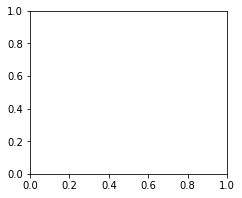

In [ ]:
#This cell ALWAYS runs into a GPU memory error and its really irritating
img = Image.open('greek/6678.jpg').convert("RGB")
pre_img = preprocess_image(img)
plt.figure(figsize=(12, 3))

plt.subplot(1,3,1)
visualize_predictions(model=bit_r152x4, image=pre_img,
                      imagenet_mapping_dict=imagenet21k_mapping,
                      model_type='bit-multiclass')

plt.subplot(1,3,2)
resnet_img = tf.image.resize(pre_img, (224, 224))
visualize_predictions(model=resnet_50, image=resnet_img,
                      imagenet_mapping_dict=imagenet1k_mapping,
                      model_type='resnet')

plt.subplot(1,3,3)
plt.imshow(pre_img[0])
plt.tight_layout()

# Transfer Learning using Greek and Buddhist images as training data, with functional resnet50 layer

[Follows closely this sample](https://github.com/raghavbali/transfer-learning-in-action/blob/master/chapter_2/Ch2_N04_Transfer_Learning_Image_Classification.ipynb)

## Train-test split

In [ ]:
from glob import glob

greek_imgs = glob('./greek/*.jpg')
buddha_imgs = glob('./buddha/*.jpg')
len(greek_imgs), len(buddha_imgs)

(543, 254)

In [ ]:
from sklearn.model_selection import train_test_split

greek_train, greek_test = train_test_split(greek_imgs, test_size=0.1,
                                       random_state=42)
buddha_train, buddha_test = train_test_split(buddha_imgs,
                                             test_size=0.1,
                                             random_state=42)

In [ ]:
len(greek_train), len(greek_test), len(buddha_train), len(buddha_test)

(488, 55, 228, 26)

In [ ]:
!ls

buddha					    download_script.py
buddha.csv				    gandhara
buddha_unfiltered.csv			    gandhara.csv
CNN_experiments.ipynb			    greek
collections-22-02-20-12_52_28-gandhara.csv  greek.csv
collections-22-02-20-13_51_13-greek.csv     greek_unfiltered.csv
collections-22-02-20-13_52_23-buddhist.csv  imagenet21k_wordnet_lemmas.txt
downloader.ipynb			    ImageNetLabels.txt
downloader.py				    preprocessing_metadata.ipynb


In [ ]:
import os
from tqdm import tqdm

TRAIN_GREEK_PATH = './train/greek/'
TRAIN_BUDDHA_PATH = './train/buddha/'

TEST_GREEK_PATH = './test/greek/'
TEST_BUDDHA_PATH = './test/buddha/'

for path in tqdm(greek_train, 
                 desc='Creating Train Dataset (greek)'):
    fn = path.split('/')[-1]
    os.rename(path, TRAIN_GREEK_PATH+fn)

for path in tqdm(buddha_train, 
                 desc='Creating Train Dataset (buddha)'):
    fn = path.split('/')[-1]
    os.rename(path, TRAIN_BUDDHA_PATH+fn)

for path in tqdm(greek_test, 
                 desc='Creating Test Dataset (greek)'):
    fn = path.split('/')[-1]
    os.rename(path, TEST_GREEK_PATH+fn)

for path in tqdm(buddha_test, 
                 desc='Creating Test Dataset (buddha)'):
    fn = path.split('/')[-1]
    os.rename(path, TEST_BUDDHA_PATH+fn)

Creating Test Dataset (buddha): 100%|██████████| 26/26 [00:00<00:00, 395.54it/s]


In [ ]:
!sudo apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (838 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 155335 files and directories currently install

In [ ]:
!tree --dirsfirst --filelimit 2 ./train/

./train/
├── buddha [228 entries exceeds filelimit, not opening dir]
└── greek [488 entries exceeds filelimit, not opening dir]

2 directories, 0 files


In [ ]:
!tree --dirsfirst --filelimit 2 ./test/

./test/
├── buddha [26 entries exceeds filelimit, not opening dir]
└── greek [55 entries exceeds filelimit, not opening dir]

2 directories, 0 files


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,\
                            classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

print('TF Version:', tf.__version__)

TF Version: 2.8.0


In [ ]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['buddha', 'greek']


def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train",
        validation_split=0.1,
        subset="training",
        class_names=['buddha', 'greek'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train",
        validation_split=0.1,
        subset="validation",
        class_names=['buddha', 'greek'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

In [ ]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 716 files belonging to 2 classes.
Using 645 files for training.
Found 716 files belonging to 2 classes.
Using 71 files for validation.


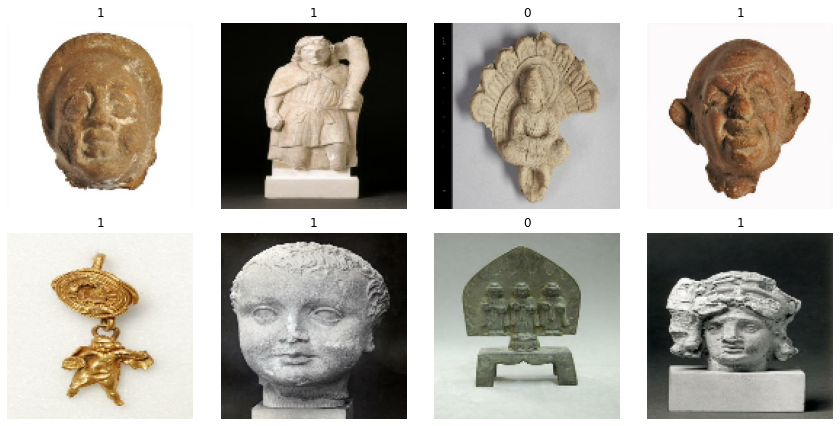

In [ ]:
plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.\
            RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.\
           RandomRotation(0.1),
        tf.keras.layers.experimental.preprocessing.\
            RandomZoom(height_factor=(0.1,0.3),
                       width_factor=(0.1,0.3))
    ]
)

In [ ]:
exft_base_resnet50 = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=IMG_SHAPE,
    weights='imagenet'
)
exft_base_resnet50.trainable = True


inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)

x = tf.keras.applications.resnet.preprocess_input(x)

x = exft_base_resnet50(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.3)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.3)(x)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

lr_finetuned_resnet50 = tf.keras.Model(inputs, outputs)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
def lr_function(epoch):
    start_lr = 1e-5; min_lr = 1e-5; max_lr = 1e-4
    rampup_epochs = 5; sustain_epochs = 0; exp_decay = .8
    
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, 
           sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) / rampup_epochs 
                        * epoch + start_lr)
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = ((max_lr - min_lr) * 
                      exp_decay**(epoch - rampup_epochs -
                                    sustain_epochs) + min_lr)
        return lr

    return lr(epoch, start_lr, min_lr, max_lr, 
              rampup_epochs, sustain_epochs, exp_decay)

In [ ]:
epochs = 100

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                     patience=5, 
                                     restore_best_weights=True),
    tf.keras.callbacks.LearningRateScheduler(lambda epoch: \
                                             lr_function(epoch), 
                                             verbose=True)
    
]

lr_finetuned_resnet50.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

history = lr_finetuned_resnet50.fit(
    train_ds, epochs=epochs, callbacks=callbacks, 
    validation_data=val_ds,
)


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/100
21/21 [==============================] - 104s 5s/step - loss: 0.6525 - accuracy: 0.6682 - val_loss: 0.5145 - val_accuracy: 0.7465 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2.8000000000000003e-05.
Epoch 2/100
21/21 [==============================] - 7s 306ms/step - loss: 0.3988 - accuracy: 0.8233 - val_loss: 0.4618 - val_accuracy: 0.8028 - lr: 2.8000e-05

Epoch 3: LearningRateScheduler setting learning rate to 4.6e-05.
Epoch 3/100
21/21 [==============================] - 7s 306ms/step - loss: 0.3188 - accuracy: 0.8713 - val_loss: 0.3691 - val_accuracy: 0.8310 - lr: 4.6000e-05

Epoch 4: LearningRateScheduler setting learning rate to 6.4e-05.
Epoch 4/100
21/21 [==============================] - 7s 297ms/step - loss: 0.2770 - accuracy: 0.8868 - val_loss: 0.4448 - val_accuracy: 0.8028 - lr: 6.4000e-05

Epoch 5: LearningRateScheduler setting learning rate to 8.2e-05.
Epoch 5/100
21/21 

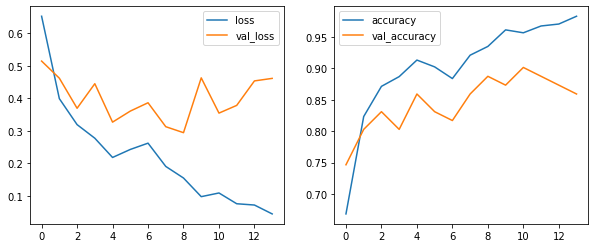

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

In [ ]:
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./test",
        class_names=['buddha', 'greek'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100), 
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    predictions = predictions.ravel()
    test_labels = np.array(test_labels)

    return test_labels, predictions

In [ ]:
y_true, y_pred = eval_model_on_test(lr_finetuned_resnet50)
predicted_labels = np.array([1 if p > 0.5 else 0 for p in y_pred])

Found 81 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


In [ ]:
print(classification_report(y_true, predicted_labels, 
                            target_names=classes))
pd.DataFrame(confusion_matrix(y_true, predicted_labels), 
             index=classes, columns=classes)

              precision    recall  f1-score   support

      buddha       0.79      0.88      0.84        26
       greek       0.94      0.89      0.92        55

    accuracy                           0.89        81
   macro avg       0.87      0.89      0.88        81
weighted avg       0.89      0.89      0.89        81



,buddha,greek
buddha,23,3
greek,6,49


In [ ]:
# Save the model
lr_finetuned_resnet50.save('models/resnet50_greek_buddhist_1')

INFO:tensorflow:Assets written to: models/resnet50_greek_buddhist_1/assets


# Visualising intermediate layers of complete model

In [ ]:
lr_finetuned_resnet50 = tf.keras.models.load_model('models/resnet50_greek_buddhist_1')

https://www.analyticsvidhya.com/blog/2020/11/tutorial-how-to-visualize-feature-maps-directly-from-cnn-layers/

In [ ]:
lr_finetuned_resnet50.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 128, 128, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 128, 128, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [ ]:
lr_finetuned_resnet50.input

<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'input_4')>

In [ ]:
for layer in lr_finetuned_resnet50.layers:
    try:
      layer.summary()
    except:
      print(layer.name, "no summary layer")

input_4 no summary layer
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 128, 128, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 128, 128, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 128, 128, 3)       0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
tf.__operators__.getitem no summary layer
tf.nn.bias_add no summary layer
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape

In [ ]:
class ResNetGandhara(tf.keras.Sequential):
    def __init__(self, input_shape=(None, 128, 128, 3), classes=2):
        super(ResNetGandhara, self).__init__()
        self.backbone_model = [layer for layer in lr_finetuned_resnet50.layers]
        #self.classificator = tf.keras.layers.Dense(classes,activation='sigmoid', name='classificator')

    def call(self, inputs):
        x = inputs
        for layer in self.backbone_model:
            x = layer(x)
        #x = self.classificator(x)
        return x
        
model = ResNetGandhara()
activation = model(input)

TypeError: ignored

In [ ]:
def Mymodel(backbone_model, classes):
    backbone = backbone_model
    x = backbone.output
    # x = tf.keras.layers.Dense(classes,activation='sigmoid')(x)
    model = tf.keras.models.Model(inputs=backbone.input, outputs=x)
    return model

input_shape = (None, 128, 128, 3)
model = Mymodel(lr_finetuned_resnet50, classes=2)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 128, 128, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 128, 128, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                    

In [ ]:
model.layers

In [ ]:
layer_outputs = [layer.output for layer in lr_finetuned_resnet50.layers]

In [ ]:
layer_names = [layer.name for layer in lr_finetuned_resnet50.layers]

In [ ]:
layer_names

['input_4',
 'sequential',
 'tf.__operators__.getitem',
 'tf.nn.bias_add',
 'resnet50',
 'global_average_pooling2d',
 'dense',
 'dropout',
 'dense_1',
 'dropout_1',
 'dense_2']

In [ ]:
#feature_map_model = tf.keras.models.Model(lr_finetuned_resnet50.inputs, layer_outputs)
feature_map_model = tf.keras.models.Model(lr_finetuned_resnet50.inputs, layer_outputs)

ValueError: ignored

In [ ]:
import numpy as np
image_path= "./gandhara/1880105.jpg"
img = tf.keras.utils.load_img(image_path, target_size=(128, 128))  
input = tf.keras.utils.img_to_array(img)   

#IMG_DIMS = (128, 128)
#BATCH_SIZE = 32
#IMG_SHAPE = IMG_DIMS + (3,)

#input = x.reshape((1,) + x.shape)                   
#input /= 255.0
input = np.reshape(input, (1, 128, 128, 3))

In [ ]:
input.shape

(1, 128, 128, 3)

In [ ]:
feature_maps = feature_map_model.predict(input)

In [ ]:
feature_maps

array([[[[133.061  , 125.221  , 119.32   ],
         [133.061  , 125.221  , 119.32   ],
         [133.061  , 125.221  , 119.32   ],
         ...,
         [132.061  , 124.221  , 118.32   ],
         [132.061  , 124.221  , 118.32   ],
         [132.061  , 124.221  , 118.32   ]],

        [[133.061  , 125.221  , 119.32   ],
         [133.061  , 125.221  , 119.32   ],
         [133.061  , 125.221  , 119.32   ],
         ...,
         [132.061  , 124.221  , 118.32   ],
         [132.061  , 124.221  , 118.32   ],
         [132.061  , 124.221  , 118.32   ]],

        [[133.061  , 125.221  , 119.32   ],
         [133.061  , 125.221  , 119.32   ],
         [133.061  , 125.221  , 119.32   ],
         ...,
         [132.061  , 124.221  , 118.32   ],
         [132.061  , 124.221  , 118.32   ],
         [132.061  , 124.221  , 118.32   ]],

        ...,

        [[128.061  , 120.221  , 114.32   ],
         [128.061  , 120.221  , 114.32   ],
         [128.061  , 120.221  , 114.32   ],
         ...,


In [ ]:
for layer_name, feature_map in zip(layer_names, feature_maps):
  print(f"The shape of the {layer_name} is =======>> {feature_map.shape}")

The shape of the input_4 is =======>> (128, 128, 3)


InvalidArgumentError: ignored

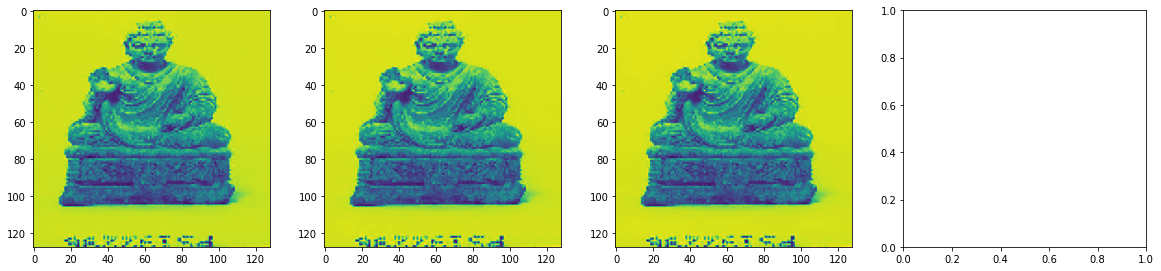

In [ ]:
activation = feature_map_model(input)

plt.figure(figsize=(20,20))
for i in range(4):
    plt.subplot(4,4,i+1)
    plt.imshow(activation[0,:,:,i])
plt.show()

New approach: https://www.kaggle.com/arpitjain007/guide-to-visualize-filters-and-feature-maps-in-cnn

In [ ]:
resnet_weights = lr_finetuned_resnet50.layers[4].get_weights()

In [ ]:
len(resnet_weights)

318

# Predictions on Gandharan datasets (no visualisation because its too painful)

In [3]:
lr_finetuned_resnet50 = tf.keras.models.load_model('models/resnet50_greek_buddhist_1')

In [6]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
gandhara_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./gandhara",
        labels=None,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

Found 196 files belonging to 1 classes.


In [21]:
file_paths = gandhara_ds.file_paths

In [14]:
out = lr_finetuned_resnet50.predict(gandhara_ds)

In [20]:
#0 is buddha and 1 is greek
predicted_labels = np.array([1 if p > 0.5 else 0 for p in out])

In [23]:
for image, prediction in zip(file_paths, predicted_labels):
  print(image, "is predicted as", prediction)

./gandhara/188606181.jpg is predicted as 0
./gandhara/188066.jpg is predicted as 0
./gandhara/190002091.jpg is predicted as 0
./gandhara/1899060949.jpg is predicted as 0
./gandhara/196702215.jpg is predicted as 0
./gandhara/186806121851.jpg is predicted as 0
./gandhara/188041.jpg is predicted as 0
./gandhara/186806121865.jpg is predicted as 0
./gandhara/1880173.jpg is predicted as 0
./gandhara/196610172.jpg is predicted as 1
./gandhara/1902100214.jpg is predicted as 1
./gandhara/196211141.jpg is predicted as 0
./gandhara/195807141.jpg is predicted as 0
./gandhara/191107176.jpg is predicted as 0
./gandhara/188076.jpg is predicted as 0
./gandhara/193207091.jpg is predicted as 0
./gandhara/1880217.jpg is predicted as 0
./gandhara/188077.jpg is predicted as 0
./gandhara/1880119.jpg is predicted as 1
./gandhara/1899060953.jpg is predicted as 0
./gandhara/188907035.jpg is predicted as 0
./gandhara/1902100218.jpg is predicted as 0
./gandhara/189208012.jpg is predicted as 0
./gandhara/18990715

In [28]:
for image, prob in zip(file_paths, out):
  print(image, "is predicted as", "{:.2f}".format(prob[0] * 100), "% greek", "{:.2f}".format((1-prob[0])*100), "% Buddhist")

./gandhara/188606181.jpg is predicted as 0.00 % greek 100.00 % Buddhist
./gandhara/188066.jpg is predicted as 0.06 % greek 99.94 % Buddhist
./gandhara/190002091.jpg is predicted as 0.01 % greek 99.99 % Buddhist
./gandhara/1899060949.jpg is predicted as 0.81 % greek 99.19 % Buddhist
./gandhara/196702215.jpg is predicted as 0.01 % greek 99.99 % Buddhist
./gandhara/186806121851.jpg is predicted as 0.05 % greek 99.95 % Buddhist
./gandhara/188041.jpg is predicted as 0.00 % greek 100.00 % Buddhist
./gandhara/186806121865.jpg is predicted as 38.23 % greek 61.77 % Buddhist
./gandhara/1880173.jpg is predicted as 0.00 % greek 100.00 % Buddhist
./gandhara/196610172.jpg is predicted as 80.24 % greek 19.76 % Buddhist
./gandhara/1902100214.jpg is predicted as 81.25 % greek 18.75 % Buddhist
./gandhara/196211141.jpg is predicted as 0.01 % greek 99.99 % Buddhist
./gandhara/195807141.jpg is predicted as 0.13 % greek 99.87 % Buddhist
./gandhara/191107176.jpg is predicted as 17.19 % greek 82.81 % Buddhist

In [ ]:
plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()